# Using Qiskit Terra


Qiskit Terra contains tools that **define**, **compile** and **execute** quantum circuits on arbitrary **backends**.
It allows users to manipulate qubits by using gates and even construct circuits at the level of **pulses**

## *Transpiling a quantum circuit*

In [7]:
# Import required fuctions from qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.backends.ibmq_vigo

ibmqfactory.load_account:WARNING:2020-06-05 10:58:32,660: Credentials are already in use. The existing account in the session will be replaced.


# What goes on under the hood when you call `execute`

### Execute calls Assemble to convert the circuit into a Qobj, which is a backend-specific object. 
### While doing so, execute also calls 

   - The transpiler, which converts the circuit into a Directed Acyclic Graph(DAG) of gates,
   - and optimizes the DAG for the target execution backend (DAGs are much easier to optimize than circuits).

### Directed Acyclic Graph (DAG)  are created using  qiskit.compiler.transpile()
### Qobjs are created  using    qiskit.compiler.assemble() 

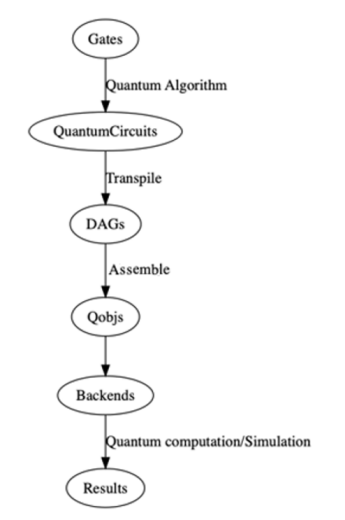

In [2]:
# let's consider this circuit
ghz = QuantumCircuit(3,3)
ghz.h(0)
ghz.cx(0,1)
ghz.cx(0,2)
ghz.measure([0,1,2], [0,1,2])
ghz.draw()

In [3]:
# let's create a "qobj" and run it on the simulator without tranpiling it
from qiskit.compiler import assemble
qobj_ghz = assemble(ghz)
print(qobj_ghz)

In [5]:
job_sim = Aer.get_backend('qasm_simulator').run(qobj_ghz)

print(job_sim.status())
print(job_sim.result().get_counts())
print(job_sim.status())

In [10]:
# let's run it on a real backend 'ibmq_vigo'
backend = provider.get_backend('ibmq_vigo')
job_real = backend.run(qobj_ghz)
print(job_real.status())
print(job_real.result())


In [11]:
# we retrieve the error message 
print(job_real.error_message())

### We can notice that we 'h' gate is not understood. The standard gates must be expanded in terms of gates supported by the decice.  
#### let's see what are the basis gates supported by the backend device 'ibmq_vigo' 

In [7]:
backend.configuration().basis_gates

['u1', 'u2', 'u3', 'cx', 'id']

We see that the device 'ibmq_vigo' supports five native gates: three single-qubit gates (u1, u2, u3, and id) and one two-qubit entangling gate cx. Although we have queried only a single device, all IBM Q devices support this gate set.

The u* gates represent arbitrary single-qubit rotations of one, two, and three angles.
The tranpiling process "Unroll" the circuit to a given basis (it uses the Unroller pass) 

### So what about removing the Hadamard gate from the circuit

In [174]:
ghz = QuantumCircuit(3,3)
#ghz.h(0)
ghz.cx(0,1)
ghz.cx(0,2)
ghz.measure([0,1,2], [0,1,2])
ghz.draw()

┌─┐   
q_0: ──■────■─────┤M├───
     ┌─┴─┐  │  ┌─┐└╥┘   
q_1: ┤ X ├──┼──┤M├─╫────
     └───┘┌─┴─┐└╥┘ ║ ┌─┐
q_2: ─────┤ X ├─╫──╫─┤M├
          └───┘ ║  ║ └╥┘
c_0: ═══════════╬══╩══╬═
                ║     ║ 
c_1: ═══════════╩═════╬═
                      ║ 
c_2: ═════════════════╩═

In [12]:
qobj_ghz = assemble(ghz)
job_real = backend.run(qobj_ghz)
print(job_real.status())
print(job_real.result())

In [13]:
# we retrieve the error message.
# We have a new error message
print(job_real.error_message())

## *Let's look at vigo' coupling map*
 

In [14]:
from qiskit.visualization import plot_gate_map
backend = provider.get_backend('ibmq_vigo')

# plot the coupling map for vigodraw the circuits 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2)
ghz.draw(output='mpl',scale=1, ax=ax[1])
plot_gate_map(backend, plot_directed=True, ax=ax[0])


###  The topology is encoded in what qiskit calls the coupling_map, and the coupling map for a device can be obtained from its configuration

In [15]:
backend = provider.get_backend('ibmq_vigo')
backend.configuration().coupling_map

### We can notice that we don't have a connection between qubit 0 and qubit 2, that's the reason of the error 
#### The goal of the transpilation is to 
- Transform a given quantum circuit into one which is executable on a specifc device, preserving measurement outcomes (compatibility)
- Find an implementation which takes maximal advantage of device resources, while minimizing infuence of decoherence and errors.(Optimization)


## *Now it's your turn to play!*
<div class="alert alert-block alert-info">
<b>Note:</b>
Here's a first challenge for you: Transpile the circuit to "Unroll" to a given basis
    
   - Transpile the circuit to unroll non-basis gates to desired basis 'u3' and 'cx' gates. 
   - Then draw the transpiled circuit and count the operations (gates)
</div>

In [203]:
# Consider the circuit below
qr = QuantumRegister(5, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.ccx(qr[0], qr[1], qr[4])
tpl_circuit.cx(qr[4], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

┌───┐          ┌───┐
q_0: ───────■──┤ X ├──■───────┤ X ├
            │  └─┬─┘┌─┴─┐┌───┐└─┬─┘
q_1: ───────■────┼──┤ X ├┤ X ├──┼──
            │    │  └───┘└─┬─┘  │  
q_2: ───────┼────┼─────────┼────┼──
     ┌───┐  │    │         │    │  
q_3: ┤ H ├──┼────┼─────────■────■──
     └───┘┌─┴─┐  │                 
q_4: ─────┤ X ├──■─────────────────
          └───┘

In [ ]:
# transpile the circuit and specify the basis gates to unroll to 



In [ ]:
# Draw the circuit when transpiled 



In [ ]:
# counts the operation in the circuit



## *Now it's your turn to play!*
<div class="alert alert-block alert-info">
<b>Note:</b>
Here's a second challenge for you: Consider the ciruit ghz2_circ below. 
 
  - First: Tranpile the circuit using "ibmq_16_melbourne" backend, and print out the count operations and depth of the transpiled circuit
  - Second: Optimize the transpilation using a specific "initial_layout" to get the best circuit depth 
    
<b>Note:</b> An initial_layout is an initial position of virtual qubits on physical qubits.
            If this layout makes the circuit compatible with the coupling_map constraints, it will be used.
            The final layout is not guaranteed to be the same, as the transpiler may permute qubits through swaps or other means.
</div> 
</div>

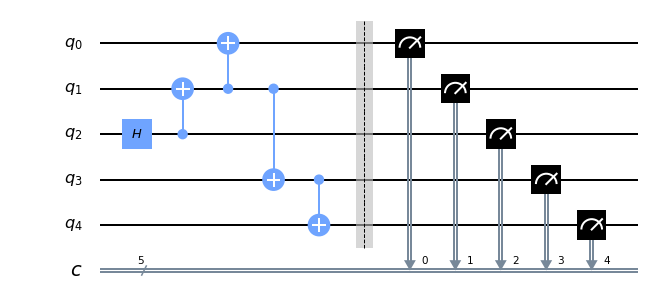

In [220]:
# Consider the circuit "ghz2_circ" below
ghz2_circ = QuantumCircuit(5, 5)
ghz2_circ.h(2)
ghz2_circ.cx(2, 1)
ghz2_circ.cx(1, 0)
ghz2_circ.cx(1, 3)
ghz2_circ.cx(3, 4)
ghz2_circ.barrier(range(5))
ghz2_circ.measure(range(5), range(5))
ghz2_circ.draw(output='mpl')

#### *First Transpile the circuit using ibm_q_16_melbourne as backend*

In [ ]:
# First set your backend as "ibm_q_16_melbourne" 



In [ ]:
# transpile your circuit using that backend



In [ ]:
# print the depth and the operation counts for that circuit



In [ ]:
# draw the circuit 



#### *Second: Use an intial layout during transilation that best matches with the circuit*

In [ ]:
# draw the coupling map of the backend "ibmq_16_melbourne"



In [ ]:
# check for a good layout by looking at to which qubits the CNOT gates are applied in the circuit



In [ ]:
# transpile using an initial_layout 



In [ ]:
print count operatins, depth of the circuit,  and draw it

